In [8]:
import numpy as np
import matplotlib.pyplot as plt

#np.random.seed(40)

# P1: Particle Metroplis-Hastings

In [9]:
# Generate data
T = 50
y = np.zeros(T)
x = np.random.normal(loc=0.0, scale=1.0, size=1)

for t in range(T):
    x = np.cos(x) + np.random.normal(loc=0.0, scale=1.0, size=1)
    y[t] = x + np.random.normal(loc=0.0, scale=1.0, size=1)

def gaussian_density(x, mu=0.0, sigma=1.0):
    return 1/np.sqrt(2 * np.pi * sigma**2) * np.exp(-0.5*((x - mu)/sigma)**2 )

def gaussian_random_walk(x, sigma=1.0):
    return np.random.normal(x, sigma)

In [65]:
def bootstrap_particle_filter(y, n_particles):
    
    T = len(y)
    x = np.random.normal(0.0, 1.0, size=n_particles)
    w = np.ones(n_particles) / n_particles
    w_tilde = np.zeros(n_particles)
    
    X = np.zeros([T, n_particles])
    W = np.zeros([T, n_particles])
    W_tilde = np.zeros([T, n_particles])
    
    for t in range(T):
        
        # Sample indeces
        a = np.random.choice(n_particles, n_particles, p=w)
        
        # Sample particles
        x = np.random.normal(loc=x[a], scale=1.0)
        
        # Compute unnormalized importance weights
        #w_tilde = gaussian_density(y[t], 0.0, np.ones(n_particles))
        #w_tilde = gaussian_density(y[t], x, np.ones(n_particles))
        w_tilde = gaussian_density(y[t], 0.0, np.sqrt(np.exp(x)))
        
        # Normalzie importance weights
        w = w_tilde / np.sum(w_tilde)
        #print("w", w)
        
        # Store particles and weights
        X[t, :] = x
        W[t, :] = w
        W_tilde[t, :] = w_tilde # used for computing the log-likelihood
        
    # Compute log-ikelihood
    logl = np.sum( np.log(np.sum(W_tilde, axis=1)) - np.log(n_particles) )
    return X, W, logl

In [66]:
def mh_algorithm(M, n_particles):
    theta_curr = np.random.normal(0.0, 1.0)
    _, _, z_hat_curr = bootstrap_particle_filter(y, n_particles=n_particles)
    
    Theta = np.zeros(M)
    Z_hat = np.zeros(M)
    count = 0
    for m in range(M):
        
        # Draw sample from proposal
        theta = gaussian_random_walk(theta_curr)
        
        # Sample from uniform distribution
        u = np.random.uniform(0.0, 1.0)
        
        # Compute acceptance probability
        x, w, z_hat = bootstrap_particle_filter(y, n_particles)
        
        p_theta = gaussian_density(theta)
        p_theta_curr = gaussian_density(theta_curr)
        
        q_theta = gaussian_density(theta, theta_curr)
        q_theta_curr = gaussian_density(theta_curr, theta)
        
        #print("numerator: ", (z_hat * p_theta * q_theta_curr))
        #print("denominator: ", z_hat_curr * p_theta_curr * q_theta)
        #print("Accept prob: ", (z_hat * p_theta * q_theta_curr)/(z_hat_curr * p_theta_curr * q_theta))
        alpha = np.minimum(1.0, (z_hat * p_theta * q_theta_curr)/(z_hat_curr * p_theta_curr * q_theta))
        
        # Set sampled theta and z_hat as current
        if u <= alpha:
            theta_curr = theta
            z_hat_curr = z_hat
            count += 1
        Theta[m] = theta_curr
        Z_hat[m] = z_hat_curr
    print("Accepted samples: ", count)
    return Theta, Z_hat

Accepted samples:  3447


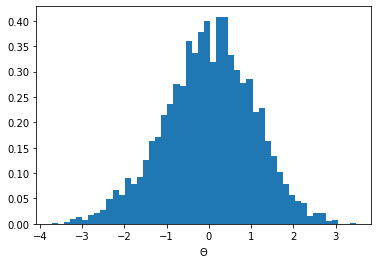

In [67]:
M = 5000
N = 200
Theta, Z_hat = mh_algorithm(M, N)
plt.hist(Theta, bins=50, density=True)
plt.xlabel("$\Theta$")
plt.show()
# Something is wrong here!
# The plot should be bimodal over theta=1 and -1!
# Maybe try another particle filter, like fully adapted PF